<a href="https://colab.research.google.com/github/Matt1368/UMD-NN-Quadrotor-/blob/main/GRU_Architecture_Quadrotors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

NaN in X_train: 0
NaN in y_train: Rotor1_Failure    0
Rotor2_Failure    0
Rotor3_Failure    0
Rotor4_Failure    0
dtype: int64
NaN in X_val: 0
NaN in y_val: Rotor1_Failure    0
Rotor2_Failure    0
Rotor3_Failure    0
Rotor4_Failure    0
dtype: int64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.1783 - loss: 0.6964 - val_accuracy: 0.4869 - val_loss: 0.6768
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3138 - loss: 0.6736 - val_accuracy: 0.3760 - val_loss: 0.6539
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4275 - loss: 0.6429 - val_accuracy: 0.6317 - val_loss: 0.6204
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4828 - loss: 0.6016 - val_accuracy: 0.6379 - val_loss: 0.5706
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5125 - loss: 0.5492 - val_accuracy: 0.6471 - val_loss: 0.5062
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5308 - loss: 0.4807 - val_accuracy: 0.6549 - val_loss: 0.4398
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5415 - loss: 0.4214 - val_accuracy: 0.6703 - val_loss: 0.3864
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5488 - loss: 0.3766 - val_accuracy: 0.

Test Loss: 0.4272
Test Accuracy: 0.6656


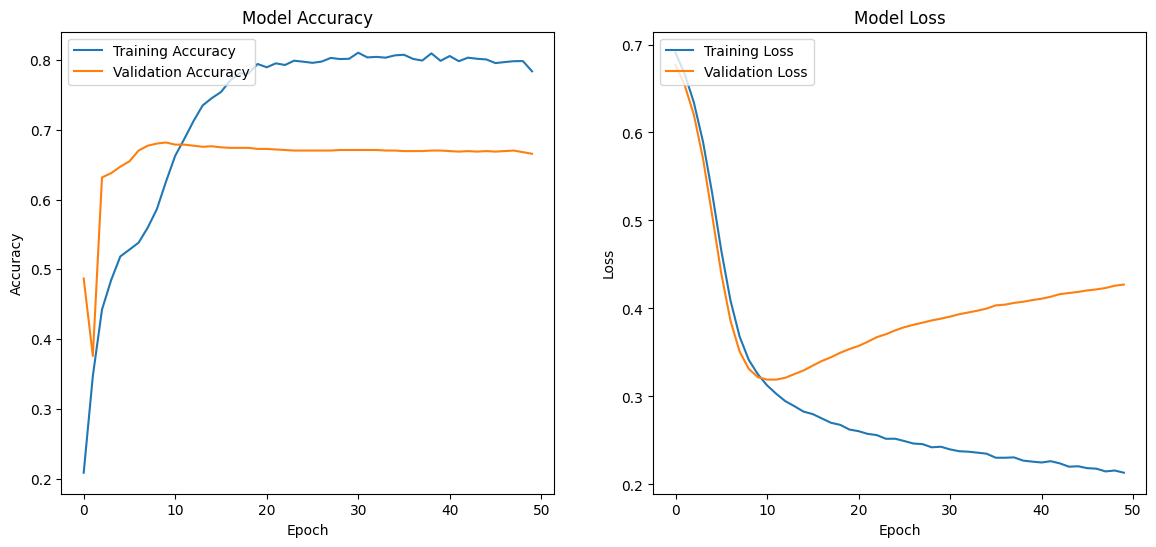

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


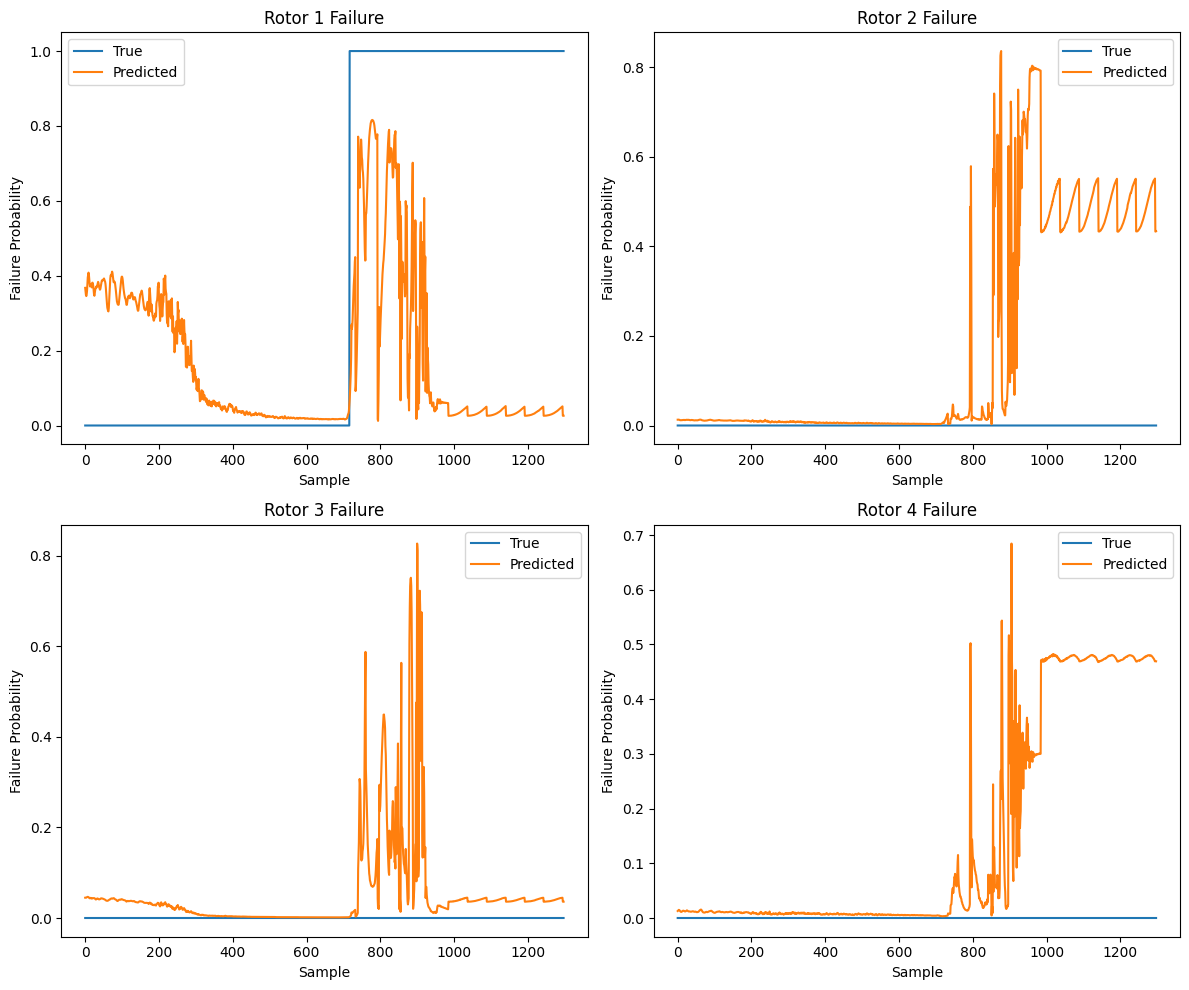

In [ ]:
# Function to load specific datasets
def load_datasets(file_list):
    data_list = []
    for file in file_list:
        data = pd.read_csv(file)
        data_list.append(data)
    combined_data = pd.concat(data_list, axis=0)
    return combined_data

# Load training and validation datasets
train_files = ['four2.csv', 'one2.csv', 'three3.csv', 'two3.csv']  # Adjust the list of files as needed
val_files = ['one3.csv']  # Adjust the list of files as needed

train_data = load_datasets(train_files)
val_data = load_datasets(val_files)

# Replace infinity values with NaN, then fill NaNs with column mean
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
val_data.replace([np.inf, -np.inf], np.nan, inplace=True)

train_data.fillna(train_data.mean(), inplace=True)
val_data.fillna(val_data.mean(), inplace=True)

# Clip very large values to a reasonable maximum (e.g., 1e6)
train_data = np.clip(train_data, -1e6, 1e6)
val_data = np.clip(val_data, -1e6, 1e6)

# Define features and labels
features_columns = ['X [m]', 'Y [m]', 'Z [m]', 'Phi [deg]', 'Theta [deg]', 'Psi [deg]', 'P [deg/s]', 'Q [deg/s]', 'R [deg/s]', 'U_dot [m/s^2]', 'V_dot [m/s^2]', 'W_dot [m/s^2]']
labels_columns = ['Rotor1_Failure', 'Rotor2_Failure', 'Rotor3_Failure', 'Rotor4_Failure']

X_train = train_data[features_columns]
y_train = train_data[labels_columns]

X_val = val_data[features_columns]
y_val = val_data[labels_columns]

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Check for any NaN values
print(f'NaN in X_train: {np.isnan(X_train).sum()}')
print(f'NaN in y_train: {np.isnan(y_train).sum()}')
print(f'NaN in X_val: {np.isnan(X_val).sum()}')
print(f'NaN in y_val: {np.isnan(y_val).sum()}')

# Reshape for GRU input: (samples, timesteps, features)
timesteps = 1
X_train = X_train.reshape((X_train.shape[0], timesteps, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], timesteps, X_val.shape[1]))

# Build the GRU model
model = Sequential()
model.add(GRU(32, return_sequences=True, input_shape=(timesteps, X_train.shape[2])))
model.add(Dropout(0.3))  # Adjust dropout rate
model.add(GRU(16))
model.add(Dropout(0.3))

model.add(Dense(4, activation='sigmoid'))  # Output layer for four rotor failures

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Save the model
model.save('quadrotor_gru_model.h5')

# Plot training & validation accuracy and loss values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Predict the test set
y_pred = model.predict(X_val)

# Plot the predictions for each rotor
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
rotor_labels = ['Rotor 1', 'Rotor 2', 'Rotor 3', 'Rotor 4']

for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(y_val.values[:, i], label='True')
    ax.plot(y_pred[:, i], label='Predicted')
    ax.set_title(f'{rotor_labels[i]} Failure')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Failure Probability')
    ax.legend()

plt.tight_layout()
plt.show()